In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from causallearn.search.ScoreBased.GES import ges

from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import pydot
import io
from IPython.display import Image, display

In [3]:
# gut microbes
gut_microbes = pd.read_csv("../datasets/gut_16s_abundance.txt", sep = "\t")
gut_microbes.head()

,SampleID,phylum_Actinobacteria,phylum_Bacteroidetes,phylum_Firmicutes,phylum_Proteobacteria,phylum_Verrucomicrobia,phylum_unclassified_Bacteria,class_Actinobacteria,class_Bacilli,class_Bacteroidia,...,genus_Veillonella,genus_unclassified_Bacteria,genus_unclassified_Clostridiales,genus_unclassified_Clostridiales_Incertae.Sedis.XIII,genus_unclassified_Coriobacteriaceae,genus_unclassified_Erysipelotrichaceae,genus_unclassified_Firmicutes,genus_unclassified_Lachnospiraceae,genus_unclassified_Porphyromonadaceae,genus_unclassified_Ruminococcaceae
0,ZOZOW1T-1010,0.000449,0.650866,0.225080,0.007364,0.015835,0.097431,0.000449,0.000138,0.650866,...,0.000000,0.097431,0.007883,0.000035,0.000415,0.002386,0.015697,0.027452,0.000000,0.074128
1,ZOZOW1T-1011,0.000176,0.730518,0.184808,0.003900,0.008186,0.070902,0.000176,0.000070,0.730518,...,0.000035,0.070902,0.008713,0.000141,0.000176,0.000808,0.008608,0.011805,0.000000,0.069215
2,ZOZOW1T-1012,0.000597,0.178364,0.796861,0.000358,0.002788,0.020911,0.000597,0.000119,0.178364,...,0.000080,0.020911,0.022903,0.000518,0.000398,0.001713,0.000876,0.018362,0.000000,0.615351
3,ZOZOW1T-1015,0.000058,0.740726,0.226516,0.005977,0.001207,0.024971,0.000058,0.000029,0.740726,...,0.000029,0.024971,0.013046,0.000086,0.000029,0.004109,0.007730,0.043849,0.000029,0.067096
4,ZOZOW1T-1021,0.001113,0.554580,0.364195,0.038358,0.000059,0.041286,0.001113,0.000059,0.554580,...,0.000410,0.041286,0.006208,0.000117,0.000176,0.000468,0.000996,0.132584,0.015753,0.044624


In [4]:
# subject data
subject_info = pd.read_csv("../datasets/subject_file.csv")
subject_info.head()

,SubjectID,Study,Race,Sex,Age,BMI,SSPG,IR_IS_classification
0,ZIS22OE,HMP,C,F,NaN,NaN,NaN,Unknown
1,ZJBOZ2X,Exercise,C,F,65.30,19.82,NaN,Unknown
2,ZJOSZHK,HMP,C,M,41.43,19.42,NaN,Unknown
3,ZJTKAE3,HMP,C,F,58.65,31.24,162.0,IR
4,ZJXC41N,"HMP, Exercise",B,F,49.69,28.24,75.0,IS


In [5]:
# add SubjectID column to gut_microbes
gut_microbes['SubjectID'] = gut_microbes['SampleID'].str.split('-').str[0]

In [24]:
gut_microbes.groupby('SubjectID').count()['SampleID'].value_counts()

SampleID
1      12
2      10
3      10
5       9
7       9
4       6
9       5
8       4
10      4
6       3
17      3
15      3
19      3
13      2
12      2
16      2
21      1
24      1
14      1
25      1
35      1
111     1
28      1
11      1
22      1
Name: count, dtype: int64

In [25]:
subject_info['Sex'].value_counts()

Sex
F    56
M    51
Name: count, dtype: int64

In [6]:
# find unique number of subjects in both datasets
# data cleaning: take their intersection (remove a few subjects)
print('Gut Microbes:', gut_microbes['SubjectID'].nunique(), '\n',
      'Subject Info:', subject_info['SubjectID'].nunique())

merged_df = pd.merge(gut_microbes, subject_info, on='SubjectID', how='inner')
merged_df.head()

Gut Microbes: 96 
 Subject Info: 107


,SampleID,phylum_Actinobacteria,phylum_Bacteroidetes,phylum_Firmicutes,phylum_Proteobacteria,phylum_Verrucomicrobia,phylum_unclassified_Bacteria,class_Actinobacteria,class_Bacilli,class_Bacteroidia,...,genus_unclassified_Porphyromonadaceae,genus_unclassified_Ruminococcaceae,SubjectID,Study,Race,Sex,Age,BMI,SSPG,IR_IS_classification
0,ZOZOW1T-1010,0.000449,0.650866,0.225080,0.007364,0.015835,0.097431,0.000449,0.000138,0.650866,...,0.000000,0.074128,ZOZOW1T,"HMP, Exercise",C,M,59.48,21.47,91.5,IS
1,ZOZOW1T-1011,0.000176,0.730518,0.184808,0.003900,0.008186,0.070902,0.000176,0.000070,0.730518,...,0.000000,0.069215,ZOZOW1T,"HMP, Exercise",C,M,59.48,21.47,91.5,IS
2,ZOZOW1T-1012,0.000597,0.178364,0.796861,0.000358,0.002788,0.020911,0.000597,0.000119,0.178364,...,0.000000,0.615351,ZOZOW1T,"HMP, Exercise",C,M,59.48,21.47,91.5,IS
3,ZOZOW1T-1015,0.000058,0.740726,0.226516,0.005977,0.001207,0.024971,0.000058,0.000029,0.740726,...,0.000029,0.067096,ZOZOW1T,"HMP, Exercise",C,M,59.48,21.47,91.5,IS
4,ZOZOW1T-1021,0.001113,0.554580,0.364195,0.038358,0.000059,0.041286,0.001113,0.000059,0.554580,...,0.015753,0.044624,ZOZOW1T,"HMP, Exercise",C,M,59.48,21.47,91.5,IS


In [11]:
merged_df['IR_IS_classification'].value_counts()

IR_IS_classification
IS         377
IR         286
Unknown    192
Name: count, dtype: int64

In [16]:
merged_df.groupby('SubjectID').first()['IR_IS_classification'].value_counts()

IR_IS_classification
Unknown    35
IR         33
IS         28
Name: count, dtype: int64

In [19]:
merged_df.groupby('SubjectID').nunique()['IR_IS_classification'].value_counts()

IR_IS_classification
1    96
Name: count, dtype: int64

In [7]:
# 6 phyla: Actinobacteria, Bacteroidetes, Firmicutes, Proteobacteria, Verrucomicrobia, Unclassified
# 12 classes
# 12 orders
# 21 families (includes unclassified)
# 45 genus (includes unclassified)

taxonomy = ['phylum', 'class', 'order', 'family', 'genus']
taxonomy_counts = {col: 0 for col in taxonomy}
for col in merged_df.columns:
    for tax in taxonomy:
        if tax in col:
            taxonomy_counts[tax] += 1
            
taxonomy_counts

{'phylum': 6, 'class': 28, 'order': 12, 'family': 21, 'genus': 45}

In [9]:
genus_col = []
for col in merged_df.columns:
    if 'genus' in col:
        genus_col.append(col)

In [10]:
genus_col

['genus_Akkermansia',
 'genus_Alistipes',
 'genus_Anaerotruncus',
 'genus_Anaerovorax',
 'genus_Bacteroides',
 'genus_Barnesiella',
 'genus_Bilophila',
 'genus_Blautia',
 'genus_Butyricicoccus',
 'genus_Butyricimonas',
 'genus_Clostridium.IV',
 'genus_Clostridium.XI',
 'genus_Clostridium.XVIII',
 'genus_Clostridium.XlVa',
 'genus_Clostridium.XlVb',
 'genus_Clostridium.sensu.stricto',
 'genus_Collinsella',
 'genus_Coprococcus',
 'genus_Dorea',
 'genus_Eggerthella',
 'genus_Erysipelotrichaceae_incertae_sedis',
 'genus_Faecalibacterium',
 'genus_Flavonifractor',
 'genus_Holdemania',
 'genus_Lachnospiracea_incertae_sedis',
 'genus_Odoribacter',
 'genus_Oscillibacter',
 'genus_Parabacteroides',
 'genus_Parasutterella',
 'genus_Phascolarctobacterium',
 'genus_Prevotella',
 'genus_Pseudoflavonifractor',
 'genus_Roseburia',
 'genus_Ruminococcus',
 'genus_Streptococcus',
 'genus_Veillonella',
 'genus_unclassified_Bacteria',
 'genus_unclassified_Clostridiales',
 'genus_unclassified_Clostridiales

In [7]:
# 1. figure out if we use linear vs non-linear methods

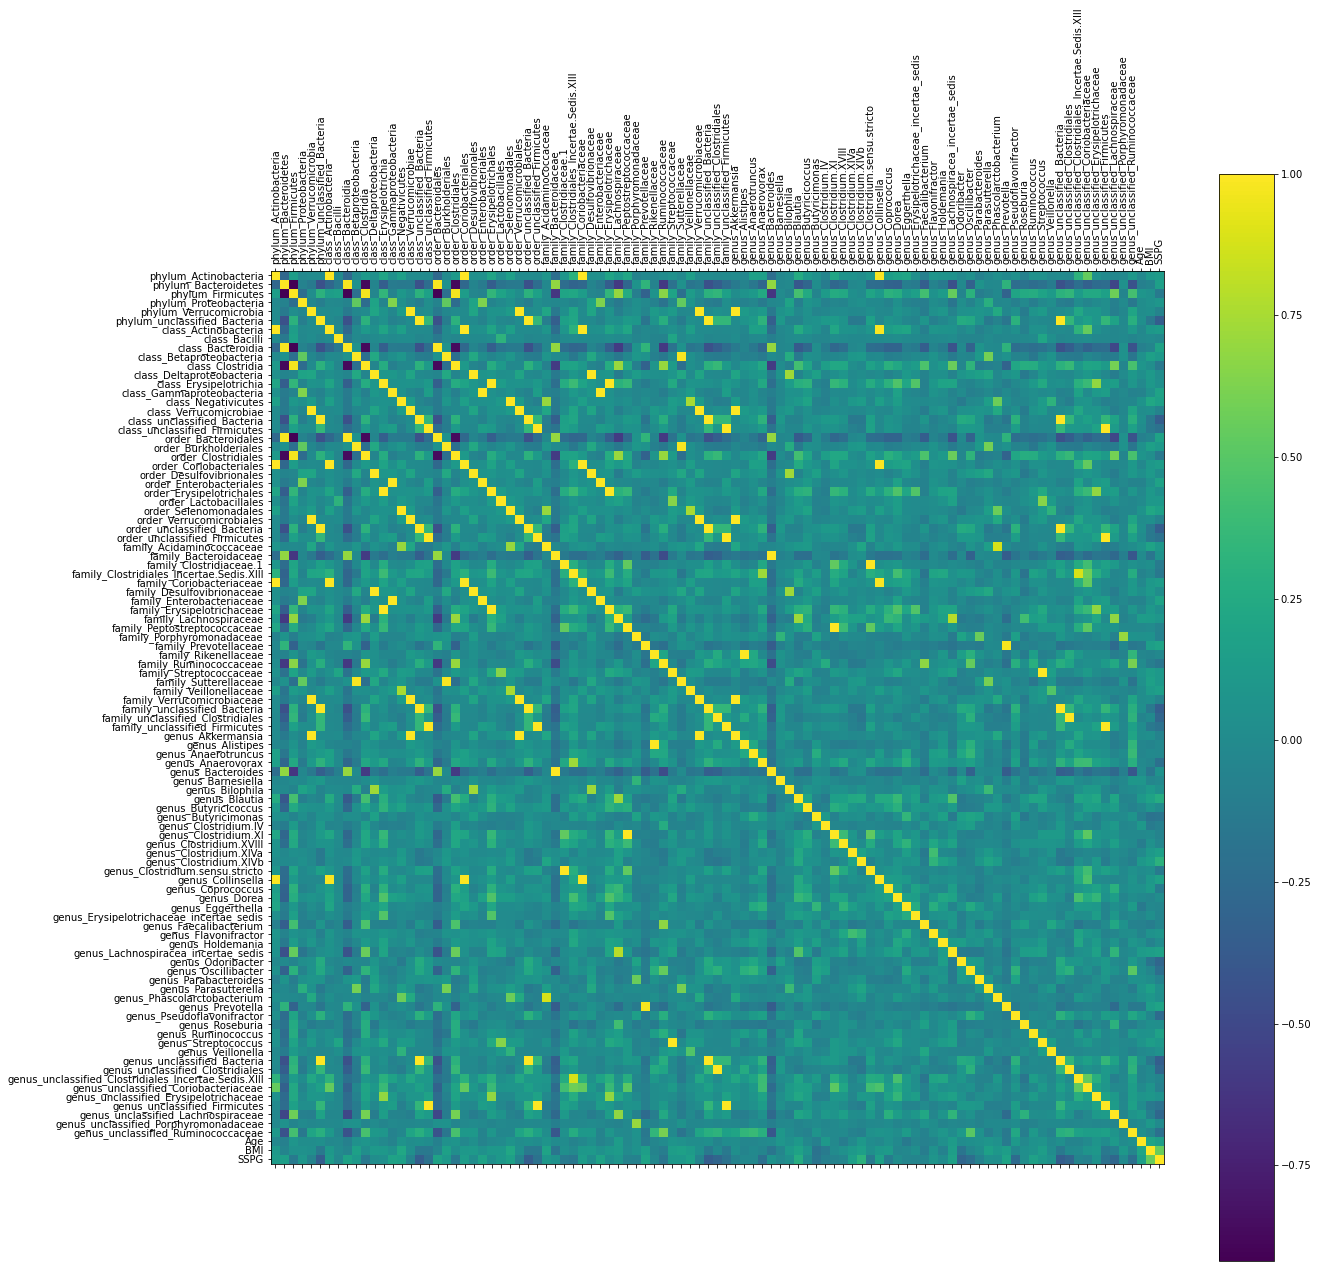

In [8]:
# correlation

X = merged_df.drop(columns = ['SubjectID', 'SampleID', 'Study', 'Race', 'Sex', 'IR_IS_classification'])

def make_corr_plot(data):
    corr = data.corr()
    full_columns = list(data.columns)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot()
    cax = ax.matshow(corr)
    fig.colorbar(cax)

    xaxis = np.arange(len(full_columns))
    ax.set_xticks(xaxis)
    ax.set_yticks(xaxis)
    ax.set_xticklabels(full_columns, rotation=90)
    ax.set_yticklabels(full_columns)

    fig.show()

    return


make_corr_plot(X)

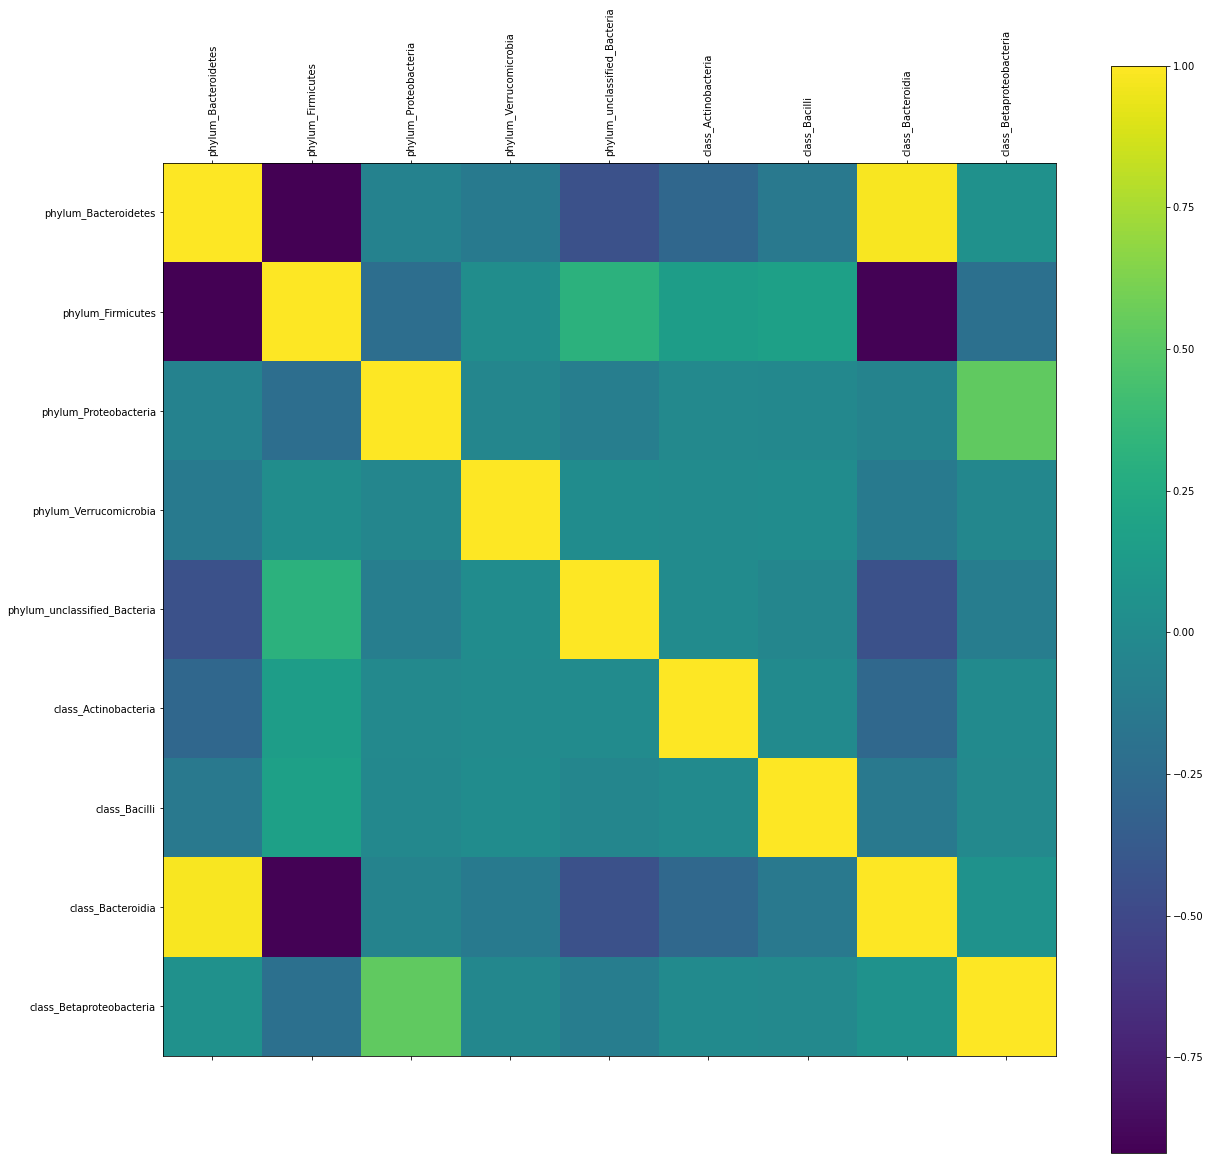

In [9]:
# smaller dataset for test run

mini_X = X.iloc[:, 1:10]

make_corr_plot(mini_X)

In [10]:
# run ges

Record = ges(mini_X.values)

In [11]:
Record

{'update1': [[7, 0, ()],
  [0, 1, ()],
  [2, 1, [0]],
  [4, 1, ()],
  [5, 1, ()],
  [3, 1, ()],
  [2, 8, ()],
  [0, 4, ()],
  [5, 0, (4,)],
  [6, 0, ()],
  [3, 0, ()],
  [2, 0, ()]],
 'update2': [],
 'G_step1': [<causallearn.graph.GeneralGraph.GeneralGraph at 0x7f6eb5917f10>,
 'G_step2': [],
 'G': <causallearn.graph.GeneralGraph.GeneralGraph at 0x7f6eb58b1fa0>,
 'score': matrix([[-50933.52156238]])}

In [15]:
# plot ges
pyd = GraphUtils.to_pydot(Record['G'], labels = mini_X.columns)
pyd.write_png('causal_graph_GES_miniX.png')
Image(filename='causal_graph_GES_miniX.png')

FileNotFoundError: [Errno 2] "dot" not found in path.